# Пробуем уменьшить th принятия решения

In [16]:
import os
import re
import pickle
import json
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from collections import defaultdict
from hack_lap.utils.evaluate import precision_recall, estimate_prediction, calculate_metrics_one_vs_rest_

In [2]:
import matplotlib
# matplotlib.use('Qt5Agg')
# %matplotlib qt5
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
DIR_DATA = os.path.join('..', 'data')
DIR_PREDICT = os.path.join(DIR_DATA, 'predict') 
DIR_MODEL = os.path.join(DIR_DATA, 'model')
MIN_F1 = 0.30

ps = re.compile(f'seed-(\d+)', re.I)
pr = re.compile(f'r-(\d+)', re.I)

files_json = [n for n in os.listdir(DIR_MODEL) if n.endswith('.json') and n.startswith('b') and 'best' in n]

files_by_try = defaultdict(list)
for f in files_json:
    seed = [int(g.group(1)) for g in ps.finditer(f)]
    r = [int(g.group(1)) for g in pr.finditer(f)]
    assert len(seed) == 1
    assert len(r) == 1
    seed = seed[0]
    r = r[0]
    files_by_try[(seed, r)].append(f)
    
files_json = []
for _, v in files_by_try.items():
    best_v = None
    best_f1 = 0.0
    for vi in v:
        with open(os.path.join(DIR_MODEL, vi)) as fp:
            res = json.load(fp)
        if best_f1 < res['best_f1']:
            best_f1 = res['best_f1']
            best_v = vi
    if best_f1 < MIN_F1:
        continue
    files_json.append((best_v, best_f1))
len(files_json)

38

In [10]:
f1

0.38139171881711037

In [50]:
f_json, f1 = files_json[30]
f = f_json.replace('json', 'pkl')
with open(os.path.join(DIR_MODEL, f), 'rb') as fp:
    data = pickle.load(fp)
yt_dev, yp_dev, yp_test = data['yt_dev'], data['yp_dev'], data['yp_test']


In [51]:
calculate_metrics_one_vs_rest_(yt_dev, yp_dev, dump_factor=1.0)

((0.9741932116778383, 0.9872944693572496, 0.9806995872821974),
 (0.5214793001905421, 0.34615384615384615, 0.4161018009978643))

In [54]:
calculate_metrics_one_vs_rest_(yt_dev, yp_dev, dump_factor=0.99)

((0.9748961539729847, 0.9857997010463379, 0.9803171098862417),
 (0.5072024260803645, 0.36538461538461536, 0.42476851519619524))

  0%|          | 0/31 [00:00<?, ?it/s]

(0.42476851519619524, 0.99)

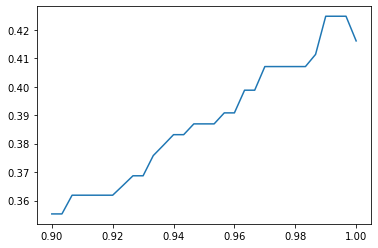

In [57]:
x = np.linspace(0.9, 1.0, 31)
s = []
for f in tqdm(x):
    _, (_, _, a) = calculate_metrics_one_vs_rest_(yt_dev, yp_dev, dump_factor=f)
    s.append(a)
    
plt.plot(x, s);

ii = np.nanargmax(s)
s[ii], x[ii]

In [58]:
x

array([0.9       , 0.90333333, 0.90666667, 0.91      , 0.91333333,
       0.91666667, 0.92      , 0.92333333, 0.92666667, 0.93      ,
       0.93333333, 0.93666667, 0.94      , 0.94333333, 0.94666667,
       0.95      , 0.95333333, 0.95666667, 0.96      , 0.96333333,
       0.96666667, 0.97      , 0.97333333, 0.97666667, 0.98      ,
       0.98333333, 0.98666667, 0.99      , 0.99333333, 0.99666667,
       1.        ])

In [5]:
predict = []
for f_json, f1 in files_json:
    f = f_json.replace('json', 'pkl')
    with open(os.path.join(DIR_MODEL, f), 'rb') as fp:
        data = pickle.load(fp)
    yt_dev, yp_dev, yp_test = data['yt_dev'], data['yp_dev'], data['yp_test']

    yp_dev = np.mean(yp_dev, axis=1).ravel()
    rp0, rp1, th = precision_recall(yt_dev, yp_dev)
    f1 = 2 * rp1[0] * rp1[1] / (rp1[0] + rp1[1] + 1e-6)
    ii = np.argmax(f1)
    f1 = f1[ii]
    th = th[ii]

    yp_test = np.mean(yp_test, axis=1)
    yp_test = (yp_test > th).astype(int).reshape(-1, 1)
    predict.append(yp_test)

In [10]:
submission = np.concatenate(predict, axis=1)
print(submission.shape[1])
submission = np.mean(submission, axis=1)
th = 0.3
y_pred = submission > th
ii = np.arange(len(y_pred))
print(np.sum(y_pred))

ii = ii[y_pred]
score = submission[y_pred]
jj = np.argsort(score)
ii = ii[jj]
score = score[jj]

38
40


In [11]:
score, ii

(array([0.31578947, 0.31578947, 0.31578947, 0.34210526, 0.34210526,
        0.34210526, 0.34210526, 0.34210526, 0.39473684, 0.42105263,
        0.42105263, 0.44736842, 0.44736842, 0.47368421, 0.47368421,
        0.47368421, 0.5       , 0.5       , 0.52631579, 0.55263158,
        0.55263158, 0.57894737, 0.60526316, 0.63157895, 0.63157895,
        0.68421053, 0.73684211, 0.78947368, 0.78947368, 0.81578947,
        0.86842105, 0.92105263, 0.92105263, 0.92105263, 0.92105263,
        0.94736842, 0.97368421, 1.        , 1.        , 1.        ]),
 array([ 747,  362,  425, 1183, 1422,   92,  908, 1379,  865,  179,  796,
        1363,   15,  518, 1165,  772, 1013,  965,  608,  643,  274, 1495,
        1256,  941,  793,  931, 1487, 1457, 1303,  690,  470,    2,  512,
        1173,  678, 1419,  841,  453,   41, 1228]))

In [21]:
df = pd.read_csv(os.path.join(DIR_DATA, 'test.csv'))
df['Score'] = submission

for i, row in df.loc[ii].iterrows():
    print(f"# {i} score: {row['Score']}")
    print(row['Smiles'])
    print()


# 1183 score: 0.42105263157894735
Cc1ccccc1N(C)C(=O)c1ccc([S+]([O-])c2nccs2)c([N+](=O)[O-])c1

# 15 score: 0.42105263157894735
CCOC(=O)OC(C)OC1=C(C(=O)Nc2ccccn2)N(C)S(=O)(=O)c2ccccc21

# 252 score: 0.42105263157894735
CC(C)(C)/[N+]([O-])=C/c1ccc(S(=O)(=O)[O-])cc1S(=O)(=O)[O-].[Na+].[Na+]

# 433 score: 0.42105263157894735
O=C1C(Cl)=C(Cl)C(=O)C(Cl)=C1Cl

# 1379 score: 0.42105263157894735
CC(C)NCCCn1c(Sc2cc3c(cc2I)OCO3)nc2c(N)ncnc21

# 1013 score: 0.42105263157894735
O=C(O)C(O)Cc1ccc(O)c(O)c1

# 608 score: 0.42105263157894735
O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)cc(O)c12

# 865 score: 0.42105263157894735
O=C([O-])O.O=S(=O)(O)c1cc(I)c(O)c2ncccc12.[Na+]

# 179 score: 0.47368421052631576
Oc1ccc(C(O)CNCCCCCCNCC(O)c2ccc(O)c(O)c2)cc1O

# 1363 score: 0.47368421052631576
OC(CN1CCC(Cc2ccc(F)cc2)CC1)c1ccc(Cl)cc1

# 518 score: 0.47368421052631576
C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.[Cl-]

# 772 score: 0.47368421052631576
C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.Cl.Nc1ccc2cc3ccc(N

In [ ]:
# 518 и 772 эквивалентны

In [23]:
# df = pd.read_csv(os.path.join(DIR_DATA, 'test.csv'))
# df['Active'] = submission

# seed_hash = hash(''.join(map(str, seeds)))
# name = f'b-L4-H32-Patt-NF-BF-#seeds-{len(seeds)}_hash-{seed_hash}_mean_th-{th}'

# df.to_csv(os.path.join(DIR_PREDICT, name + '.csv'), index=False)

# with open(os.path.join(DIR_PREDICT, name + '.json'), 'w') as fp:
#     json.dump({'seeds': seeds}, fp, indent=2)